# This notebook exemplifies the calculation of the horizontal and vertical derivatives by using the *classical equivalent layer* approach.

In [1]:
# Import all python modules
import numpy
from matplotlib import pyplot

In [2]:
from codes.auxiliars import regional

In [3]:
# Import some developed modules
from codes.prism import prism_gz
from codes.sphere import sphere_gz
from codes.grids import regular_grid
from codes.equivalentlayer import layer, mat_grav_gz

In [4]:
# Statistical module
from codes.auxiliars import addnoise
from codes.statistical import analysis

In [5]:
# Data shape:
ndata = 50
shape = (ndata, ndata)

In [6]:
# Number of observations:
xo, yo, zo = regular_grid((-2000., 2000., -2000., 2000.), shape, -200.)

In [7]:
# Synthetic data produced by a vertical dike model (vertical attraction):
# (xmin, xmax, ymin, ymax, zmin, zmax, rho(km/m3) )
dike1 = (-300., 150., -100., 280., 100., 750., 2800.0)
dike2 = (1000., 1350., 1400., 1680., 90., 1950., 2900.0)
gz = prism_gz(xo, yo, zo, dike1) + prism_gz(xo, yo, zo, dike2)

In [8]:
print 'Analysing gz data:'
_ = analysis(gz)

Analysing gz data:
Minimum:    0.0869
Maximum:    6.3167
Mean value: 1.1018
Variation:  6.2298


In [9]:
# Adding noise
gz = addnoise(gz, 1., 0.1)

In [10]:
print 'Analysing noised gz data:'
_ = analysis(gz)

Analysing noised gz data:
Minimum:    0.9393
Maximum:    7.4108
Mean value: 2.1013
Variation:  6.4715


#### Creating the equivalent layer:

In [11]:
# Define a mesh of masses point with unit volume:
# 1) horizontal coordinates:
area = (-2000., 2000., -2000., 2000.) # meters
shape_layer = (60, 60)
# 2) define the depth of the layer and the number of point in area:
eqlayer = layer(area, shape_layer, 700.)

In [12]:
# computing the Jacobian matrix:
A = mat_grav_gz(xo, yo, zo, eqlayer)

In [13]:
# dimensions of the sensitivity matrix of the eqlayer problem:
M = shape_layer[0] * shape_layer[1]
N = shape[0] * shape[1]
print 'Number of observations:', N
print 'Number of depth sources:', M

Number of observations: 2500
Number of depth sources: 3600


### Solve the least-square problem for the two possible cases:

In [14]:
# Estimation of vector parameters:
if N >= M: #overdetermined case
    mu = 0.0
    I = numpy.identity(M)
    trace = numpy.trace(A.T.dot(A))/M
    vec = numpy.linalg.solve(numpy.dot(A.T, A) + mu*trace*I, numpy.dot(A.T,gz))
else:# underterminated case
    mu = 1.e-2
    I = numpy.identity(N)
    trace = numpy.trace(A.T.dot(A))/N
    aux = numpy.linalg.solve(numpy.dot(A, A.T) + mu*trace*I, gz)
    vec = numpy.dot(A.T, aux)

In [15]:
# Computing the predicted data
gz_predicted = numpy.dot(A, vec)

In [16]:
print 'Original gz_data:'
_ = analysis(gz)
print 'Predicted gz data:'
_ = analysis(gz_predicted)

Original gz_data:
Minimum:    0.9393
Maximum:    7.4108
Mean value: 2.1013
Variation:  6.4715
Predicted gz data:
Minimum:    1.0269
Maximum:    6.7736
Mean value: 2.1011
Variation:  5.7467


In [17]:
from codes.auxiliars import residual

In [18]:
res, norm, mean, deviation = residual(gz, gz_predicted)

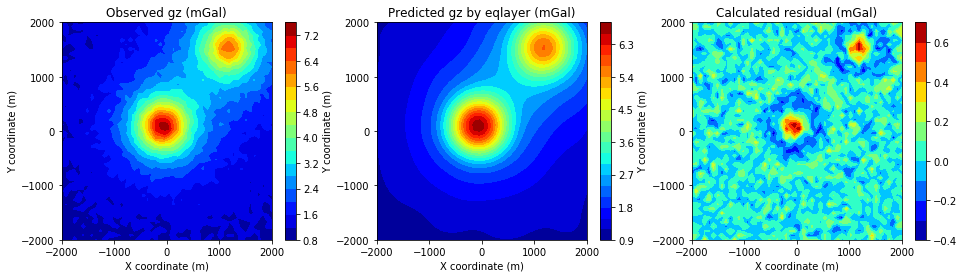

In [45]:
pyplot.figure(figsize=(16, 4))

pyplot.subplot(1, 3, 1)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gz.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Observed gz (mGal)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 2)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gz_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Predicted gz by eqlayer (mGal)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 3)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                res.reshape(ndata,ndata), 10, cmap = pyplot.cm.jet)
pyplot.title('Calculated residual (mGal)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()

# Test for tensor elements

In [20]:
# Variation along the directinos
delta = 10.

**Calculating the numerical derivative**

In [21]:
# In X
xi = prism_gz(xo - delta, yo, zo, dike1) + prism_gz(xo - delta, yo, zo, dike2)
xf = prism_gz(xo + delta, yo, zo, dike1) + prism_gz(xo + delta, yo, zo, dike2)
diffx = (xf - xi)/(2.*delta)

In [22]:
# In Y
yi = prism_gz(xo, yo - delta, zo, dike1) + prism_gz(xo, yo - delta, zo, dike2)
yf = prism_gz(xo, yo + delta, zo, dike1) + prism_gz(xo, yo + delta, zo, dike2)
diffy = (yf - yi)/(2.*delta)

In [23]:
# In X
zi = prism_gz(xo, yo, zo - 0.1*delta, dike1) + prism_gz(xo, yo, zo - 0.1*delta, dike2)
zf = prism_gz(xo, yo, zo + 0.1*delta, dike1) + prism_gz(xo, yo, zo + 0.1*delta, dike2)
diffz = (zf - zi)/(2.*0.1*delta)

In [24]:
# Import the transformation matrix for derivatives
from codes.equivalentlayer import layer, mat_grav_gz, mat_grav_gz_xyz

In [26]:
gzx, gzy, gzz = mat_grav_gz_xyz(xo, yo, zo, eqlayer)

In [36]:
# Computing the tensor elements
gzx_predicted = numpy.dot(gzx, vec)
gzy_predicted = numpy.dot(gzy, vec)
gzz_predicted = numpy.dot(gzz, vec)

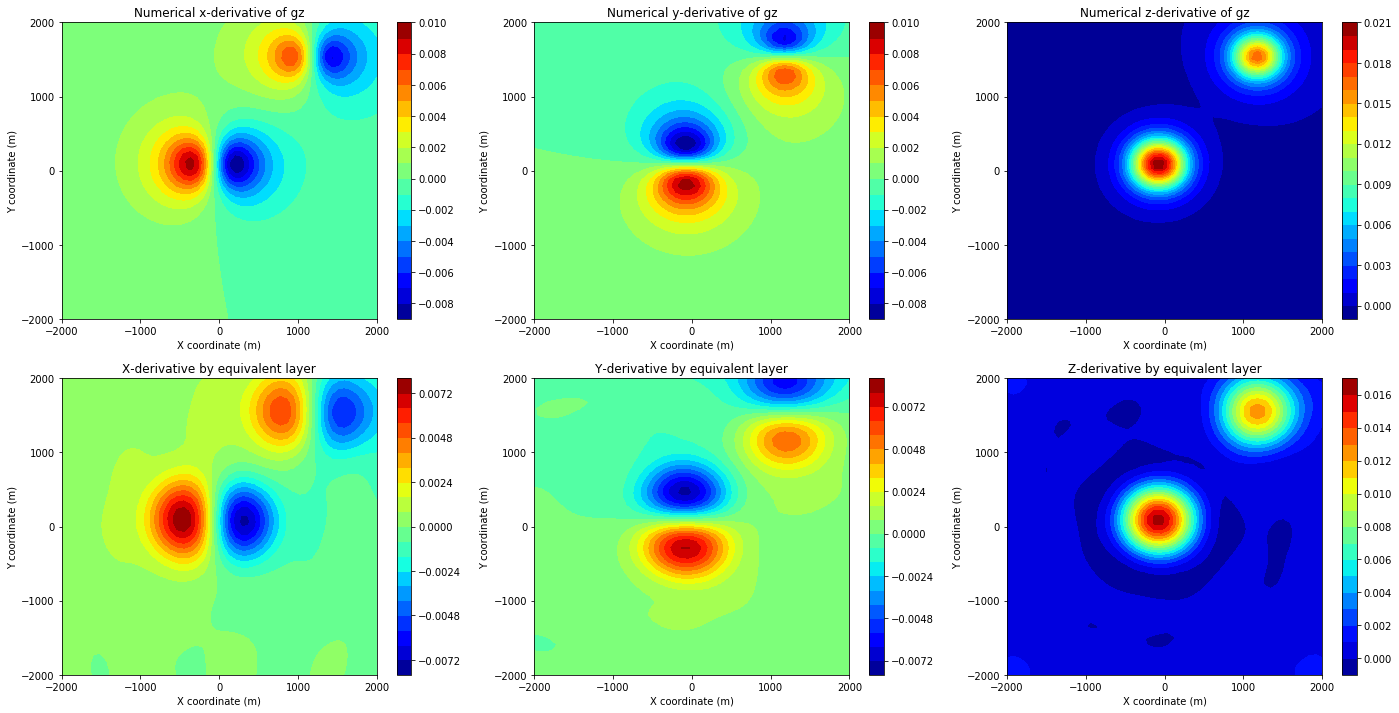

In [52]:
pyplot.figure(figsize=(24, 12))

pyplot.subplot(2, 3, 1)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                diffx.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Numerical x-derivative of gz')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 2)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                diffy.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Numerical y-derivative of gz')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 3)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                diffz.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Numerical z-derivative of gz')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 4)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gzx_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('X-derivative by equivalent layer')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 5)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gzy_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Y-derivative by equivalent layer')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 6)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gzz_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Z-derivative by equivalent layer')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()